# Kalman Filtering

v1.0 (2020 Spring): Aditya Sengupta, William Gan, Kannan Ramchandran

In [6]:
from kalman_utils import *

## Introduction

In this lab, we'll cover applications of the Kalman filter, which is the optimal linear algorithm for sensor fusion: combining information from sensors and from an underlying physics model of a system to get the best possible state estimate.

At its core, the Kalman filter is optimal because it incorporates covariance matrices. As an example, suppose I’m trying to estimate a random variable $X$, and my current estimate is $\hat{X} = 10$. I have another random variable $Y = X + W$, where $W$ is some noise, and upon observing $Y$, I see that it’s 15. How should I update $\hat{X}$ then? Should it be 12.5? Well, if $X$ has very low variance, then maybe it should be closer to 10. If $W$ has very large variance, then an observation of 15 might not be too crazy, so it should be closer to 10 as well. In the opposite situations, we could see why it might be closer to 15. Based on the covariance matrices of $X$ and $W$, we can figure out what optimizes minimum mean square error.

In more detail, say our current estimate of a random variable $X$ is $\hat{X}$ and we have Gaussian covariance $\Sigma_1$ around it. Suppose we then observe $Y \sim \mathcal{N}(X, \Sigma_2)$, and want to update our estimate; this comes out to 

$$\hat{X}_{\text{updated}} = \hat{X} + \Sigma_1(\Sigma_1 + \Sigma_2)^{-1}(Y - \hat{X}) = \hat{X} + K(Y - \hat{X})$$
$$\Sigma_{\text{updated}} = \Sigma_1 - \Sigma_1(\Sigma_1 + \Sigma_2)^{-1}\Sigma_1 = (I - K)\Sigma_1$$

These are essentially taking the first Gaussian, and adjusting it so that it ends up somewhere in between the first and the second one. We can pull out a common "adjustment factor", $K = \Sigma_1(\Sigma_1 + \Sigma_2)^{-1}$, and call it the Kalman gain. The estimate increases with a factor proportional to the Kalman gain, and the covariance reduces by a factor proportional to the Kalman gain.

The rest of the Kalman filter math just deals with how to set up these two Gaussians, which will turn out to only require a few matrix multiplications!

## Dependencies

This lab needs the Python package `pyautogui`, which provides functions to control your computer's mouse and keyboard. If you don't already have it, you can pip install it:

In [2]:
!pip3 install pyautogui -q
import pyautogui

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


## Q1: Visualizing the Filter's Action

Before we implement the filter, let's visualize how it reduces state error. Suppose we can describe a system's state in a vector $\vec{x} = \begin{matrix} [x_1 & x_2] \end{matrix}^\intercal$. At a certain time, we can make a prediction of that state based on the last state, and then we can measure the state to see how far off that prediction is. Neither of these estimates are perfect, but by somehow averaging them, we can get the best fused estimate!

### Question 1a: Plotting Different Averages
In the following cells, implement two different ways of averaging $\hat{x}$ and $y$.
1. The unweighted average of the two data points, in `unweighted_average`
2. The weighted average considering the full covariance elements, in `overlap_mean_and_covs`

The cell after that plots three ways of overlapping the estimates: the unweighted average, the weighted average with only diagonal variances, and the full weighted average. You should be able to see the 1 SD ellipse around the estimate (in purple) shrinking as we incorporate more and more information!

In [3]:
def unweighted_average(x_hat, y):
    ### BEGIN YOUR SOLUTION
    return (x_hat + y) / 2 
    ### END YOUR SOLUTION

In [4]:
def overlap_mean_and_covs(x_hat, sigma_1, y, sigma_2):
    ### BEGIN YOUR SOLUTION
    k = sigma_1 @ np.linalg.inv(sigma_1 + sigma_2)
    x_hat_updated = x_hat + k @ (y - x_hat) 
    sigma_updated = sigma_1 - k @ sigma_1
    ### END YOUR SOLUTION
    return x_hat_updated, sigma_updated

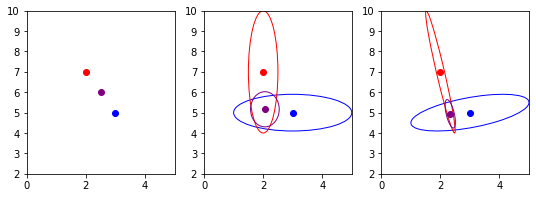

In [7]:
prediction = np.array([3, 5])
measurement = np.array([2, 7])
prediction_cov = np.array([[4, 1], [1, 0.81]])
measurement_cov = np.array([[0.25, -1.44], [-1.44, 9]])

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

for i in range(3):
    axs[i].set_xlim([0, 5])
    axs[i].set_ylim([2, 10])
    axs[i].scatter(*prediction, color='blue')
    axs[i].scatter(*measurement, color='red')

axs[0].scatter(*unweighted_average(prediction, measurement), color='purple')

plot_one_sd_blob(prediction, np.diag(np.diag(prediction_cov)), axs[1], edgecolor='blue')
plot_one_sd_blob(measurement, np.diag(np.diag(measurement_cov)), axs[1], edgecolor='red')
mean_b, cov_b = overlap_mean_and_covs(prediction, np.diag(np.diag(prediction_cov)), measurement, np.diag(np.diag(measurement_cov)))
axs[1].scatter(*mean_b, color='purple')
plot_one_sd_blob(mean_b, cov_b, axs[1], edgecolor='purple')

plot_one_sd_blob(prediction, prediction_cov, axs[2], edgecolor='blue')
plot_one_sd_blob(measurement, measurement_cov, axs[2], edgecolor='red')
mean_c, cov_c = overlap_mean_and_covs(prediction, prediction_cov, measurement, measurement_cov)
axs[2].scatter(*mean_c, color='purple')
plot_one_sd_blob(mean_c, cov_c, axs[2], edgecolor='purple')

Feel free to play around with the means/covariances (although if you set the covariance to be something that isn't positive semidefinite, it'll try to take the square root of a negative number and the results won't be valid).

### Question 1b: Comparing Averages

**Where does the original, unweighted average of the two points lie in relation to the overlap? Is it a good estimate of the weighted average?**

It is not a good estimate.

## Q2: Implementation and Kinematics

Let's implement a generic Kalman filter, and then apply it to some simple dynamic models!

The predict/update equations are reproduced here from the note on the website, with the equation numbers from that note:

$\hat{X}_{n + 1 \mid n} = A \hat{X}_{n \mid n}  \text{(eq 6)}\\
\Sigma_{n + 1 \mid n} = A\Sigma_{n \mid n} A^\intercal + \Sigma_V  \text{(eq 11)}\\
K_n = \Sigma_{n + 1 \mid n} C^\intercal (C \Sigma_{n + 1 \mid n} C^\intercal + \Sigma_W)^{-1}  \text{(eq 10)}\\
\hat{X}_{n + 1 \mid n + 1} = \hat{X}_{n + 1 \mid n} + K(Y_n - C\hat{X}_{n + 1 \mid n})  \text{(eq 8)}$


### Question 2a: Implementation

**Fill in the code to complete the ```predict``` and ```update``` functions below.** It may be helpful to refer to the vector case Kalman filter equations from the notes. A few clarifications:

- `self.state` is our current estimate $\hat{X}_n$.
- `self.P` is the covariance around the current estimate $\Sigma_{n \mid n}$.
- `self.Q` is $\Sigma_V$, `self.R` is $\Sigma_W$.
- In `predict`, change `self.state` to $\hat{X}_{n + 1 \mid n}$ and `self.P` to $\Sigma_{n+1 \mid n}$.
- In `update`, calculate `self.K` (if not in steady state), and change `self.P` to $\Sigma_{n+1 \mid n+1}$. Also update `self.state` to $\hat{X}_{n+1}$.

In [12]:
class KFilter(AbstractKFilter):
    def __init__(self, A, Q, C, R, state=None):
        self.A = A # state transition matrix
        self.Q = Q # process noise covariance
        self.C = C # measurement matrix
        self.R = R # measurement noise covariance
        self.s = A.shape[0] # state size
        self.m = C.shape[0] # measurement size
        if state is None:
            self.state = np.zeros(self.s)
        else:
            self.state = state
        self.prev_P = np.zeros((self.s, self.s)) # previous covariance
        self.P = np.zeros((self.s, self.s))      # current covariance
        self.steady_state = False
    
    def predict(self):
        self.prev_P = copy.deepcopy(self.P)
        ### BEGIN YOUR SOLUTION
        self.state = self.A @ self.state
        self.P = self.A @ self.P @ self.A.T + self.Q
        ### END YOUR SOLUTION
        
    def update(self, measurement):
        if not self.steady_state:
            ### BEGIN YOUR SOLUTION
            self.K = self.P @ self.C.T @ np.linalg.inv(self.C @ self.P @ self.C.T + self.R)
            self.P -= self.K @ (self.C @ self.P)
            ### END YOUR SOLUTION
            if np.allclose(self.P, self.prev_P):
                self.steady_state = True
        ### BEGIN YOUR SOLUTION
        innovation = measurement - self.C @ self.state
        self.state = self.state + self.K @ innovation
        ### END YOUR SOLUTION

You can run the following test to verify your code.

In [13]:
def test_predict_and_update():
    A = np.array([[2, 1], [1, 2]])
    Q = np.array([[1, 0], [1, 1]])
    C = np.array([[1, 1]])
    R = np.array([[0.5]])
    state = np.array([3, 1])
    kf = KFilter(A, Q, C, R, state)
    kf.predict()
    assert np.allclose(kf.prev_P, np.array([[0, 0], [0, 0]]))
    assert np.allclose(kf.state, np.array([7, 5]))
    assert np.allclose(kf.P, np.array([[1, 0], [1, 1]]))
    kf.update(np.array([11]))
    assert np.allclose(kf.K, np.array([[2/7], [4/7]]))
    assert np.allclose(kf.P, np.array([[3/7, -2/7], [-1/7, 3/7]]))
    assert np.allclose(kf.state, np.array([47/7, 31/7]))
    print('All assertions passed')

In [14]:
test_predict_and_update()

All assertions passed


Now let's try some simple examples! To start with, let's consider some object that we start at rest, and that moves under some unknown random forces. We won't deal with modelling these forces yet; we'll just consider how they impact position and velocity over time.

In [15]:
dt = 1e-3
kinematics_data = pd.read_csv('kinematics.csv', header=0) 
times = kinematics_data['t']
measurements_k = kinematics_data['measurements']

Text(0.5, 1.0, 'Measurements')

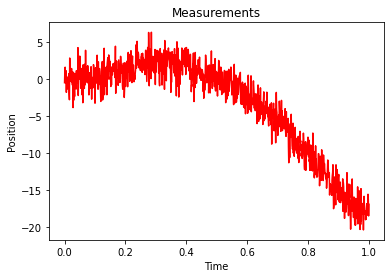

In [16]:
plt.plot(times, measurements_k, color='red')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Measurements')

We see that the measurements are too noisy for us to have an accurate idea of where the object is over time, but since we know the laws of motion it follows, we can improve that estimate a lot!

### Question 2b: Linear Tracking
**Based on the following information, define the matrices A, Q, C, R below and run the filter to generate MMSE estimates of position and velocity.**
1. The object moves according to $ p[n+1] = p[n] + v[n] \Delta t $, where $ \Delta t = 10^{-3} $ s (this was defined above in the variable `dt`).
2. The velocity is expected to stay constant, but may be perturbed by a force that causes a $\mathcal{N}(0, 1)$ change.
3. Measurements are only of position, and have a *standard deviation* of 1.5.

Once these have been defined, the line `states_2b = kinematics_forward.simulate(measurements_k)` will iterate through the measurements, compute the predictions and state updates, and return an array of size (state_size, num_timesteps) containing the state at each timestep. (The number of timesteps is set by the number of measurements; here it's 1000.)

In [28]:
### BEGIN YOUR SOLUTION
A = np.array([[1, dt], [0, 1]])
Q = np.array([[dt**2, dt], [dt, 1]])
#Q = np.array([[0, 0], [0, 1]])
C = np.array([[1, 0]])
R = np.array([[2.25]])
### END YOUR SOLUTION
kinematics_forward = KFilter(A, Q, C, R)
states_2b = kinematics_forward.simulate(measurements_k)

Percent error of measurements from truth: 5.52
Percent error of KFilter predictions from truth: 1.49


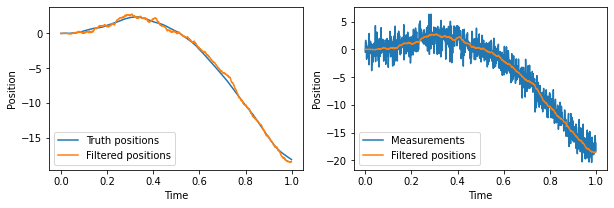

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(times, kinematics_data["truth_p"], label='Truth positions')
axs[0].plot(times, states_2b[0], label='Filtered positions') # YOUR ESTIMATE HERE
axs[0].legend()
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Position')
axs[1].plot(times, measurements_k, label='Measurements')
axs[1].plot(times, states_2b[0], label='Filtered positions') # YOUR ESTIMATE HERE
axs[1].legend()
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Position')
pos_error_measurements = percent_rms_err(kinematics_data['truth_p'], measurements_k)
pos_error_predictions = percent_rms_err(kinematics_data['truth_p'], states_2b[0]) # YOUR ESTIMATE HERE
print(f'Percent error of measurements from truth: {pos_error_measurements:.2f}')
print(f'Percent error of KFilter predictions from truth: {pos_error_predictions:.2f}')

Another thing we can do is look at velocity! If you try to numerically differentiate velocity (take pointwise differences and divide them by the time interval), it's really sensitive to little perturbations and won't have much coherence over time. If you run the cell below, you'll see that the measurement of velocity (differences in position between steps, divided by the time-step) is off by orders of magnitude, and also has high variance: it's essentially white noise.

Percent error of differentiated positions from truth: 2906.18


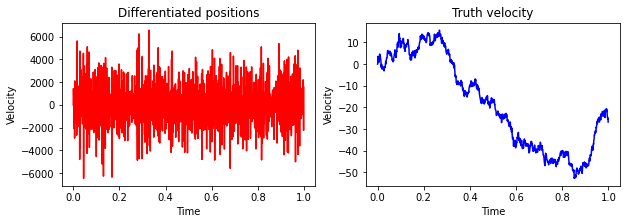

In [30]:
differentiated_positions = np.insert(np.diff(measurements_k), 0, 0) / dt
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(times, differentiated_positions, color='red')
axs[0].set_title('Differentiated positions')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Velocity')
axs[1].plot(times, kinematics_data['truth_v'], color='blue')
axs[1].set_title('Truth velocity')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Velocity')
vel_error_diff = percent_rms_err(differentiated_positions, kinematics_data['truth_v'])
print(f'Percent error of differentiated positions from truth: {vel_error_diff:.2f}')

To contrast that, let's plot the Kalman filtered velocity, which gives us the MMSE of velocity over time!

Percent error of KFilter predictions from truth: 11.70


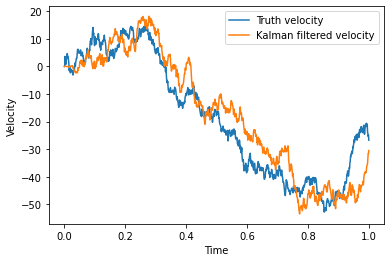

In [31]:
plt.plot(times, kinematics_data['truth_v'], label='Truth velocity')
plt.plot(times, states_2b[1], label='Kalman filtered velocity') # YOUR ESTIMATE HERE
plt.legend()
plt.xlabel("Time")
plt.ylabel("Velocity")
vel_error_predictions = percent_rms_err(states_2b[1], kinematics_data['truth_v'])
print(f'Percent error of KFilter predictions from truth: {vel_error_predictions:.2f}')

We still don't have any direct measurements of velocity, but we've been able to leverage what we know about the state and measurement variances to get a much better estimate!

### Question 2c: Kalman Smoothing

In real-time control situations, the above is the best estimate we're able to get. However, when we're postprocessing, we can also run the filter *backwards* and average the two results to smooth out the estimates.

**(i)** Modify any of the input matrices as needed to create a filter that runs backwards in time through all the measurements, and produce state estimates from that. Then, average the two runs and compare the RMS errors in position and velocity to those from the forward run.

In [32]:
### BEGIN YOUR SOLUTION
A_back = np.array([[1, -dt], [0, 1]])
Q_back = Q
C_back = C
R_back = R
### END YOUR SOLUTION

In [34]:
kinematics_backward = KFilter(A_back, Q_back, C_back, R_back, states_2b.T[-1])
reversed_measurements = kinematics_data['measurements'][::-1]
states_2c = np.flip(kinematics_backward.simulate(reversed_measurements), axis=1)
smooth_states = (states_2b + states_2c) / 2
pos_error_smooth = percent_rms_err(smooth_states[0], kinematics_data["truth_p"]) # YOUR POS ESTIMATE HERE
vel_error_smooth = percent_rms_err(smooth_states[1], kinematics_data["truth_v"]) # YOUR VEL ESTIMATE HERE
print(f'Old Position Error: {pos_error_predictions:.2f} New Error: {pos_error_smooth:.2f}')
print(f'Old Velocity Error: {vel_error_predictions:.2f} New Error: {vel_error_smooth:.2f}')

Old Position Error: 1.49 New Error: 1.24
Old Velocity Error: 11.70 New Error: 7.84


**(ii)** Look at the covariance matrices for the forward and backward directions. What differences do you see between them? Why do you think that is?

In [35]:
kinematics_forward.P

array([[167.05244619, 315.43117457],
       [315.43117457, 793.76798779]])

In [36]:
kinematics_backward.P

array([[ 165.80535652, -313.85814141],
       [-313.85814141,  793.78629626]])

YOUR ANSWER HERE

### Question 2d: Mouse Movement

We can easily extend our one-dimensional tracker to two dimensions; by doing this, we've developed a filter that'll accurately return states of, for example, a robot moving around on a flat plane. In this question, we'll explore how to tune and interpret such a model, using the movement of your mouse across your computer screen as measurements! 

In the cell below, define your own A, Q, C, R matrices by making a model that you think accurately represents moving your mouse across the screen (with an added measurement noise term, to more closely model a real-life system). Then run the cell, move your mouse around the screen, and see how well your filter does! Play around with the $Q$ and $R$ values, or with the way you move your mouse, and note how performance changes. Try and get the RMS error below the baseline (by more than a pixel). 

General comments to help you do this:
- $x$ and $y$ motion can be modeled independently of one another, both similarly to how you did it in 2b (you may also make a more complicated model here and see how it affects the error).
- $Q$ and $R$ can be diagonal matrices in almost every use case, and the diagonal values can be tuned based on what works. How much do you think is reasonable for process error in this case? Measurement error?
- It's also okay to change $dt$, though that shouldn't be necessary.

Once you've done this, briefly answer the following questions!

Start moving!

Baseline          25.455844122715714 px
Tracker RMS Error 23.630923730633043 px


Text(0.5, 1.0, 'Residuals')

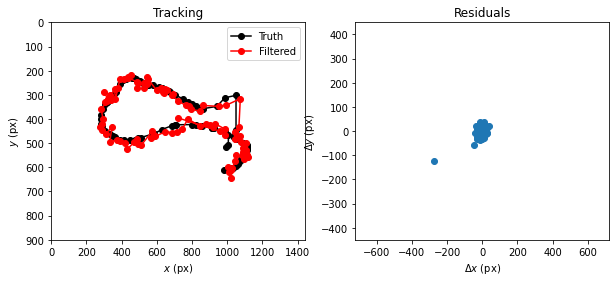

In [39]:
num_iters = 100
measurement_error_sd = 20 * min(pyautogui.size()) / 1000
dt = 1e-1
A = np.array([[1, dt, dt**2/2, 0, 0, 0], 
              [0, 1, dt, 0, 0, 0], 
              [0, 0, 1, 0, 0, 0], 
              [0, 0, 0, 1, dt, dt**2/2], 
              [0, 0, 0, 0, 1, dt], 
              [0, 0, 0, 0, 0, 1]]
            ) # state is xp, xv, xa, yp, yv, ya

Q = np.diag(np.array([49, 1, 0, 49, 1, 0]))
C = np.array([[1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]])
R = np.diag(np.array([0.25 + measurement_error_sd, 0.25 + measurement_error_sd]))

tracker = KFilter(A, Q, C, R)
predictions = np.zeros((num_iters, 2))
updates = np.zeros((num_iters, 2))
truths = np.zeros((num_iters, 2))

print("Start moving!")
time.sleep(1)
iters = 0
total_error = 0

duration = dt
while iters < num_iters:
    t = time.time() * 1e6
    tracker.predict()
    prediction = tracker.measure()
    predictions[iters] = prediction
    m = np.array(pyautogui.position() + np.random.normal(0, measurement_error_sd, (2,)))
    truths[iters] = np.array(pyautogui.position())
    tracker.update(m)
    updated = tracker.measure()
    updates[iters] = updated
    if iters > 0: # skip the first iteration because the initial state is likely far off
        total_error += np.sum((updated - truths[iters]) ** 2)
    iters += 1
    duration = (time.time() * 1e6 - t) / 1e6
    time.sleep(max(0, dt - duration))

print("\nBaseline         ", np.sqrt(2) * measurement_error_sd, "px")
print("Tracker RMS Error", np.sqrt(total_error / iters), "px")
screensize = pyautogui.size()
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].set_xlim((0, screensize[0]))
axs[0].set_ylim((screensize[1], 0))
axs[0].set_xlabel(r"$x$ (px)")
axs[0].set_ylabel(r"$y$ (px)")
axs[0].plot(truths[:,0], truths[:,1], 'ko-', label='Truth')
axs[0].plot(updates[:,0], updates[:,1], 'ro-', label='Filtered')
axs[0].set_title("Tracking")
axs[0].legend()
axs[1].set_xlim((-screensize[0]/2, screensize[0]/2))
axs[1].set_ylim((-screensize[1]/2, screensize[1]/2))
axs[1].set_xlabel(r"$\Delta x$ (px)")
axs[1].set_ylabel(r"$\Delta y$ (px)")
axs[1].scatter(*(updates.T - truths.T))
axs[1].set_title("Residuals")

In [40]:
tracker.P

array([[14.21011595,  1.7838906 ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.7838906 , 63.02120701,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        , 14.21011595,  1.7838906 ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.7838906 , 63.02120701,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

**(i) Briefly describe how you defined $A$, $Q$, $C$, and $R$, and report the approximate tracker RMS error.**

YOUR ANSWER HERE

**(ii) While varying the model parameters, you may have seen the tracker doing about the same as the baseline (if you didn't, try setting $Q$ really low or really high.) What might cause this?**

YOUR ANSWER HERE

### Q3: Sinusoidal Motion and System Identification

So far we've only discussed linear motion, but it's possible to build models (choices of $A, Q, C, R$) that let us track a signal that's the solution to any ordinary differential equation. Partial differential equations are possible too, but more complicated.

In particular, we'll deal with _autoregressive_ tracking of a sinusoidal signal, i.e. one of the form $x(t) = A \sin(2\pi f t + \phi)$. In this case, $A, f, \phi$ are all unknowns, but we'll see that all we need to identify is $f$.

Instead of a position/velocity state like we used in question 2, here we'll use the state $\vec{x}[n] = \begin{bmatrix} p[n] & p[n-1] \end{bmatrix}^\intercal$: the state is the combination of the current position and the last one. Further, we can find the update rule by solving a boundary value problem:

$ p[n] = 2\cos(2\pi f \Delta t) p[n-1] - p[n-2] $ .

### System Identification

Identifying the frequency is an example of a *system identification* step: something we need to do before we start tracking so that we can build the best possible model. In this example, time-domain methods aren't the most efficient for finding frequencies, so instead we'll do a Fourier transform and choose the peak.

The cell below generates a sinusoidal signal with position and velocity variances given by `q_pos` and `q_vel`, but with hidden amplitude, frequency, and phase. It then computes a Fourier transform of the measured positions and finds the location of the peak.

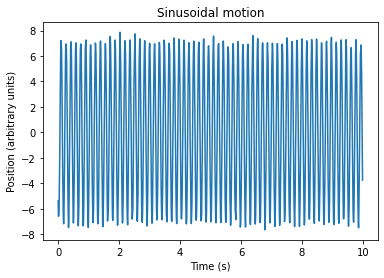

6.2


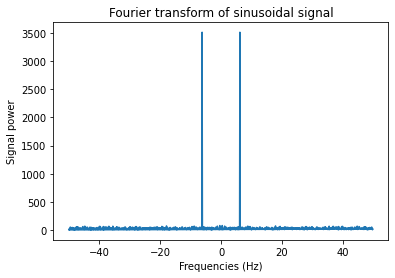

In [42]:
dt = 1e-2
times = np.arange(0, 1000 * dt, dt)
sinusoid = make_sinusoid(times, dt, q_pos=0.05, q_vel=0.05)
plt.plot(times, sinusoid)
plt.xlabel("Time (s)")
plt.ylabel("Position (arbitrary units)")
plt.title("Sinusoidal motion")
plt.show()

measurements = sinusoid + np.random.normal(0, 1, times.size)

# we don't know the frequency, so let's find it with Fourier analysis
freqs = np.fft.fftfreq(measurements.size, d=dt)
transformed = np.abs(np.fft.fft(measurements))
plt.plot(freqs, transformed)
plt.xlabel("Frequencies (Hz)")
plt.ylabel("Signal power")
plt.title("Fourier transform of sinusoidal signal")

f = freqs[np.argmax(transformed[1:transformed.size // 2]) + 1]
print(f)

We're cheating a little bit here: by doing this analysis to find $f$, we're assuming we've already seen all the measurements instead of getting them in real time. In practice, it's usually okay to assume that the frequency won't change much over time, so you can measure for a few seconds to find $f$ and then use it in the filter, maybe continuing to update as you go. For this lab, we won't worry about that.

### Question 3a: Autoregressive Sinusoid Tracker

**Fill in the code defining the sine-tracking filter below, and run the filter on the measurements.**

In [52]:
A = np.array([[2*np.cos(2*np.pi*f*dt), -1],[1, 0]])
Q = np.array([[0.05, 0],[0.05, 1]])
C = np.array([[1, 0]])
R = np.array([[10]])
sinetracker = KFilter(A, Q, C, R)

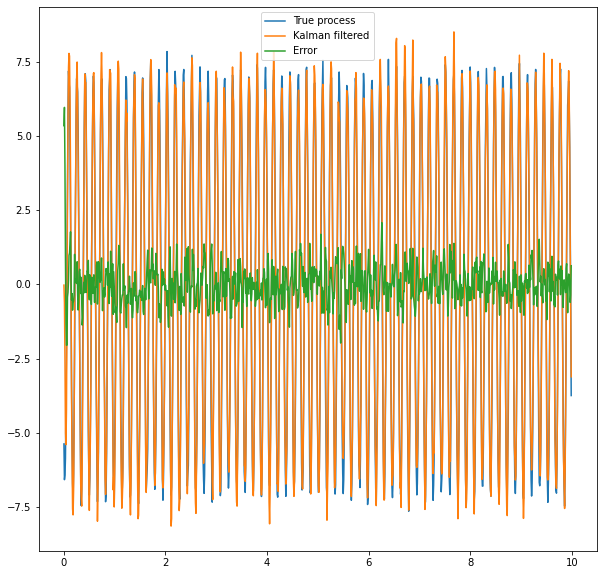

In [53]:
states = sinetracker.simulate(measurements)
plt.figure(figsize=(10,10))
plt.plot(times, sinusoid, label="True process")
plt.plot(times, states[0], label="Kalman filtered")
plt.plot(times, states[0] - sinusoid, label="Error")
plt.legend()

In [54]:
sine_measure_err = rms(sinusoid - measurements)
sinetrack_err = rms(sinusoid[50:] - states[0][50:]) # average only after initial convergence

print(f'Absolute error of measurements from truth: {sine_measure_err:.2f}')
print(f'Absolute error of KFilter predictions from truth: {sinetrack_err:.2f}')

Absolute error of measurements from truth: 1.00
Absolute error of KFilter predictions from truth: 0.60


### Question 3b: System Misidentification

**Suppose we misidentified the frequency, and so our $A$ is wrong. Is it still possible to get decent state estimates? Experiment in the cells below, and answer below that.**

In [58]:
bad_freq = 1.5 * f
A[0][0] += 2 * np.sin(np.pi * (f + bad_freq) * dt) * np.sin(np.pi * (f - bad_freq) * dt) # trig magic
# change any of these as needed
### BEGIN YOUR CODE
Q = Q * 1000
C = C
R = R / 10
### END YOUR CODE
bad_sinetracker = KFilter(A, Q, C, R)

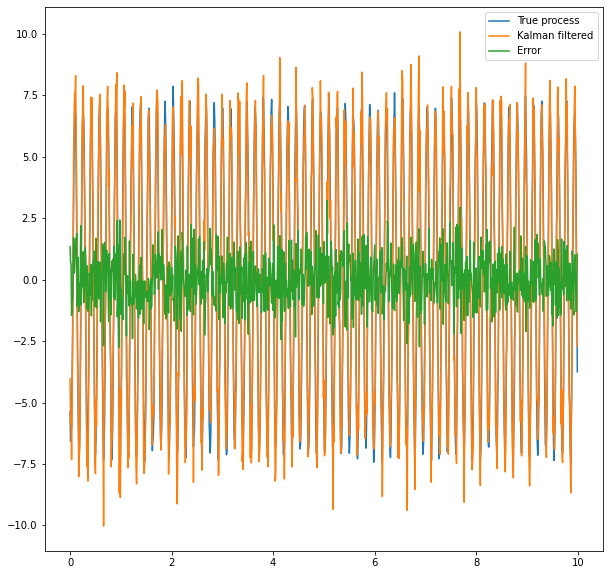

In [59]:
bad_states = bad_sinetracker.simulate(measurements)
plt.figure(figsize=(10,10))
plt.plot(times, sinusoid, label="True process")
plt.plot(times, bad_states[0], label="Kalman filtered")
plt.plot(times, bad_states[0] - sinusoid, label="Error")
plt.legend()

In [60]:
sine_measure_err = rms(sinusoid - measurements)
sinetrack_err = rms(sinusoid[50:] - bad_states[0][50:]) # average only after initial convergence

print(f'Absolute error of measurements from truth: {sine_measure_err:.2f}')
print(f'Absolute error of KFilter predictions from truth: {sinetrack_err:.2f}')

Absolute error of measurements from truth: 1.00
Absolute error of KFilter predictions from truth: 1.00


### Question 3c: Generating a Sine Wave

The autoregressive model is just one way to track a sinusoidal signal, or one that's the solution to a differential equation: here, we'll briefly investigate another.

Suppose we have a signal that can be expressed as the solution to a differential equation

$$a_0 x(t) + a_1 x^{(1)}(t) + a_2 x^{(2)}(t) + \dots + a_n x^{(n)}(t) = 0$$

where the $x^{(i)}$s denote the $i$th derivatives. The following function generates a valid choice of the $A$ and $C$ matrices we need for the Kalman filter in the _controller canonical form_ (for what this means and how this works, see a control theory class like EE C128):

In [61]:
def model_from_DE(coeffs, dt=1e-3):
    # coeffs : list, coeffs[i] = a_i
    A, C, dt = cont2discrete(tf2ss([1], coeffs), dt)[::2]
    transform = np.fliplr(np.identity(A.shape[0]))
    return transform.dot(A).dot(transform), C.dot(transform)

**To test this, fill in the following line of code to generate a sine wave (which obeys $\ddot{x} = -(2\pi)^2 f^2 x$) that makes 4 oscillations in 10 seconds (1000 timesteps), by repeatedly applying the $A$ and $C$ matrices.**

In [66]:
num_steps = 1000
dt = 1e-2
DE_coeff = np.array([1, 0, (2*np.pi)**2*f**2])

Text(0.5, 1.0, 'Sine wave generated from state-space model')

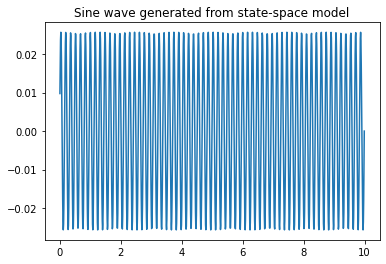

In [67]:
A, C = model_from_DE(DE_coeff, dt)
times = np.arange(0, num_steps * dt, dt)
state = np.array([0, 1])
obs = np.zeros(1000,)
for i in range(1000):
    state = A @ state
    obs[i] = C @ state
plt.plot(times, obs)
plt.title('Sine wave generated from state-space model')

### Question 3d: Applying the Controller Canonical Model

**If you go back and use this model in the above example, you'll find that tracking is, at best, not much better than the autoregressive case (maybe a 10% reduction in error at most). Why might this happen?**

YOUR ANSWER HERE

### Conclusion

In this lab, we've mostly focused on one aspect of Kalman filtering, namely postprocessing noisy measurements. This was so that we could illustrate the filter without the complexities of real-time control, which is the main topic of several other classes. However, the filter has many other applications and extensions. Some possible fun reads if you really love Kalman filtering now:

1. [Kalman filtering for improving the precision of GPS](https://conference.scipy.org/proceedings/scipy2018/pdfs/mark_wickert_247.pdf)
2. [A Kalman filter that learns its own transition model online](https://www.sciencedirect.com/science/article/abs/pii/S0262885612001783)
3. [The Extended Kalman filter (EKF), which linearizes nonlinear systems so that we can still use the Kalman filter on them](https://www.cse.sc.edu/~terejanu/files/tutorialEKF.pdf)
4. [The Ensemble Kalman filter (EnKF), which uses Monte Carlo methods to avoid doing derivatives in EKF problems](ftp://ftp.esat.kuleuven.be/pub/stadius/gillijns/reports/TR-05-58.pdf)
5. [A Kalman filter in the frequency domain](https://arxiv.org/pdf/1808.08442.pdf)

**Sources/References**

1. https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/
2. https://matplotlib.org/3.1.1/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py
3. https://stackoverflow.com/questions/3129322/how-do-i-get-monitor-resolution-in-python/14124257
4. https://www.cs.utexas.edu/~teammco/misc/kalman_filter/